## Train, tune, and deploy a custom ML model using Steel Strip Surface Defects Classifier Algorithm from AWS Marketplace 


Image analytics-based solution to classify salient surface defects in steel strip.



This sample notebook shows you how to train a custom ML model using Steel Strip Surface Defects Classifier from AWS Marketplace.

> **Note**: This is a reference notebook and it cannot run unless you make changes suggested in the notebook.

#### Pre-requisites:
1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to For Seller to update: Steel Strip Defect Detection. 

#### Contents:
1. [Subscribe to the algorithm](#1.-Subscribe-to-the-algorithm)
1. [Prepare dataset](#2.-Prepare-dataset)
	1. [Dataset format expected by the algorithm](#A.-Dataset-format-expected-by-the-algorithm)
	1. [Configure and visualize train and test dataset](#B.-Configure-and-visualize-train-and-test-dataset)
	1. [Upload datasets to Amazon S3](#C.-Upload-datasets-to-Amazon-S3)
1. [Train a machine learning model](#3:-Train-a-machine-learning-model)
	1. [Set up environment](#3.1-Set-up-environment)
	1. [Train a model](#3.2-Train-a-model)
1. [Deploy model and verify results](#4:-Deploy-model-and-verify-results)
    1. [Deploy trained model](#A.-Deploy-trained-model)
    1. [Create input payload](#B.-Create-input-payload)
    1. [Perform real-time inference](#C.-Perform-real-time-inference)
    1. [Visualize output](#D.-Visualize-output)
    1. [Calculate relevant metrics](#E.-Calculate-relevant-metrics)
    1. [Delete the endpoint](#F.-Delete-the-endpoint)
1. [Tune your model! (optional)](#5:-Tune-your-model!-(optional))
	1. [Tuning Guidelines](#A.-Tuning-Guidelines)
	1. [Define Tuning configuration](#B.-Define-Tuning-configuration)
	1. [Run a model tuning job](#C.-Run-a-model-tuning-job)
1. [Perform Batch inference](#6.-Perform-Batch-inference)
1. [Clean-up](#7.-Clean-up)
	1. [Delete the model](#A.-Delete-the-model)
	1. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))


#### Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

### 1. Subscribe to the algorithm

To subscribe to the algorithm:
1. Open the algorithm listing page Steel Strip Defect Detection
1. On the AWS Marketplace listing,  click on **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn**. This is the algorithm ARN that you need to specify while training a custom ML model. Copy the ARN corresponding to your region and specify the same in the following cell.

In [70]:
algo_arn = 'arn:aws:sagemaker:us-east-2:786796469737:algorithm/steel-surface-defect-detection-notebook-test'

### 2. Prepare dataset

In [71]:
import base64
import json 
import uuid
import sagemaker as sage
from sagemaker import get_execution_role
from urllib.parse import urlparse
import urllib.request
import boto3
from zipfile import ZipFile
from PIL import Image
import io
import pandas as pd

#### A. Dataset format expected by the algorithm

<font color='red'>***Describing the training data inputs***</font>

#### B. Configure and visualize train dataset

In [72]:
training_dataset='Training Inputs/training/data.zip'

In [73]:
image_zip = ZipFile(training_dataset)

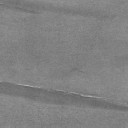

In [74]:
Image.open(io.BytesIO(image_zip.read(image_zip.namelist()[1])))

#### C. Upload datasets to Amazon S3

In [75]:
sagemaker_session = sage.Session()
bucket=sagemaker_session.default_bucket()

In [76]:
# training input location
common_prefix = "steel-defect"
training_input_prefix = common_prefix + "/training-input-data"
TRAINING_WORKDIR = "Training Inputs/training"
training_input = sagemaker_session.upload_data(TRAINING_WORKDIR, key_prefix=training_input_prefix)
print("Training input uploaded to " + training_input)

Training input uploaded to s3://sagemaker-us-east-2-786796469737/steel-defect/training-input-data


## 3: Train a machine learning model

Now that dataset is available in an accessible Amazon S3 bucket, we are ready to train a machine learning model. 

### 3.1 Set up environment

In [77]:
role = get_execution_role()

In [78]:
output_location = 's3://{}/steel_defect/{}'.format(bucket, 'output')

### 3.2 Train a model

You can also find more information about hyperparameters in **Hyperparameters** section of Steel Strip Defect Detection

In [79]:
#Define hyperparameters
hyperparameters={"no_epochs":1, "max_try":1}

For information on creating an `Estimator` object, see [documentation](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html)

In [80]:
#Create an estimator object for running a training job
estimator = sage.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    base_job_name="steel-defect-training",
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    input_mode="File",
    output_path=output_location,
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters,
    instance_count=1,
    instance_type='ml.m5.large'
)
#Run the training job.
estimator.fit({"training": training_input})

2021-11-22 08:25:50 Starting - Starting the training job...
2021-11-22 08:26:12 Starting - Launching requested ML instancesProfilerReport-1637569549: InProgress
...
2021-11-22 08:26:43 Starting - Preparing the instances for training.........
2021-11-22 08:28:13 Downloading - Downloading input data
2021-11-22 08:28:13 Training - Downloading the training image......
2021-11-22 08:29:19 Uploading - Uploading generated training model2021-11-22 08:29:02.915450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-22 08:29:02.915489: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Starting the training.
2021-11-22 08:29:07.809670: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.

#015 1/43 [..............................] - ETA: 15s - loss: 1.9456 - accuracy: 0.1250#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 2/43 [>.............................] - ETA: 2s - loss: 1.9310 - accuracy: 0.5625 #010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/43 [=>............................] - ETA: 3s - loss: 1.9102 - accuracy: 0.7083#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010


2021-11-22 08:29:53 Completed - Training job completed
ProfilerReport-1637569549: NoIssuesFound
Training seconds: 89
Billable seconds: 89


See this [blog-post](https://aws.amazon.com/blogs/machine-learning/easily-monitor-and-visualize-metrics-while-training-models-on-amazon-sagemaker/) for more information how to visualize metrics during the process. You can also open the training job from [Amazon SageMaker console](https://console.aws.amazon.com/sagemaker/home?#/jobs/) and monitor the metrics/logs in **Monitor** section.

### 4: Deploy model and verify results

Now you can deploy the model for performing real-time inference.

In [81]:
model_name='steel-defect'

content_type='application/zip'

real_time_inference_instance_type='ml.m5.large'
batch_transform_inference_instance_type='ml.m5.large'

#### A. Deploy trained model

In [82]:
from sagemaker.predictor import csv_serializer
predictor = estimator.deploy(1, real_time_inference_instance_type)

..........
-----!

Once endpoint is created, you can perform real-time inference.

#### B. Create input payload

In [89]:
file_name = '"Model Input"/inference.zip'

#### C. Perform real-time inference

In [90]:
output_file_name = '"Model Output"/output.csv'

In [91]:
!aws sagemaker-runtime invoke-endpoint \
    --endpoint-name $predictor.endpoint_name \
    --body fileb://$file_name \
    --content-type $content_type \
    --region $sagemaker_session.boto_region_name \
    $output_file_name

{
    "ContentType": "text/csv; charset=utf-8",
    "InvokedProductionVariant": "AllTraffic"
}


#### D. Visualize output

In [92]:
pd.read_csv("Model Output/output.csv")

,filename,model_prediction
0,1231.jpg,red iron
1,1232.jpg,red iron
2,1233.jpg,red iron
3,1234.jpg,red iron
4,1235.jpg,red iron
5,1236.jpg,red iron
6,1237.jpg,red iron
7,1238.jpg,red iron
8,2390.jpg,red iron
9,2391.jpg,red iron


#### F. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. you can terminate the same to avoid being charged.

In [93]:
predictor.delete_endpoint(delete_endpoint_config=True)

Since this is an experiment, you do not need to run a hyperparameter tuning job. However, if you would like to see how to tune a model trained using a third-party algorithm with Amazon SageMaker's hyperparameter tuning functionality, you can run the optional tuning step.

### 5. Perform Batch inference

In this section, you will perform batch inference using multiple input payloads together.

In [94]:
#upload the batch-transform job input files to S3
transform_input_folder = "Model Input/inference.zip"
transform_input = sagemaker_session.upload_data(transform_input_folder, key_prefix=model_name) 
print("Transform input uploaded to " + transform_input)

Transform input uploaded to s3://sagemaker-us-east-2-786796469737/steel-defect/inference.zip


In [95]:
#Run the batch-transform job
transformer = estimator.transformer(1, batch_transform_inference_instance_type)
transformer.transform(transform_input, content_type=content_type)
transformer.wait()

..........
........................2021-11-22 08:42:29.292874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-22 08:42:29.292914: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
 * Serving Flask app 'serve' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on all addresses.
 * Running on http://169.254.255.131:8080/ (Press CTRL+C to quit)
169.254.255.130 - - [22/Nov/2021 08:42:35] "GET /ping HTTP/1.1" 200 -
169.254.255.130 - - [22/Nov/2021 08:42:35] "#033GET /execution-parameters HTTP/1.1#033" 404 -
169.254.255.130 - - [22/Nov/2021 08:42:35] "GET /ping HTTP/1.1" 200 -
169.254.255.130 - - [22/Nov/2021 08:42:35] "#033GET /execution-parameters HTTP/1.1#033" 404 -
2021-11-22T08:42:35.398

In [96]:
#output is available on following path
transformer.output_path

's3://sagemaker-us-east-2-786796469737/steel-defect-training-2021-11-22-08-38-37-500'

### 6. Clean-up

#### A. Delete the model

In [97]:
transformer.delete_model()

#### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the algorithm, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

